<a href="https://colab.research.google.com/github/Kush-Singh-26/Learning-Pytorch/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import zipfile
import requests

from PIL import Image
from torchvision import datasets, models
from torchvision import transforms as transforms

In [2]:
!pip install torchinfo

In [3]:
from torchinfo import summary
from torch.utils.data import DataLoader

In [4]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

In [5]:
download_file(
    'https://www.dropbox.com/s/0ltu2bsja3sb2j4/caltech256_subset.zip?dl=1',
    'caltech256_subset.zip'
)

In [6]:
file = 'caltech256_subset.zip'
with zipfile.ZipFile(file, 'r') as zip:
    # extract all files
    print('extraction...')
    zip.extractall()
    print('Done!')

extraction...
Done!


In [7]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),  # Randomly crop the image with scaling
        transforms.RandomRotation(degrees=15),  # Apply random rotation up to 15 degrees
        transforms.RandomHorizontalFlip(),  # Flip the image horizontally with a probability of 0.5
        transforms.CenterCrop(size=224),  # Crop the center of the image to 224x224 pixels
        transforms.ToTensor(),  # Convert image to PyTorch tensor format
        transforms.Normalize([0.485, 0.456, 0.406],  # Normalize image using mean
                             [0.229, 0.224, 0.225])  # Normalize image using std deviation
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),  # Resize the image to 256 pixels on the shorter side
        transforms.CenterCrop(size=224),  # Crop the center of the image to 224x224 pixels
        transforms.ToTensor(),  # Convert image to PyTorch tensor format
        transforms.Normalize([0.485, 0.456, 0.406],  # Normalize image using mean
                             [0.229, 0.224, 0.225])  # Normalize image using std deviation
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),  # Resize the image to 256 pixels on the shorter side
        transforms.CenterCrop(size=224),  # Crop the center of the image to 224x224 pixels
        transforms.ToTensor(),  # Convert image to PyTorch tensor format
        transforms.Normalize([0.485, 0.456, 0.406],  # Normalize image using mean
                             [0.229, 0.224, 0.225])  # Normalize image using std deviation
    ])
}

In [8]:
dataset = 'caltech256_subset'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

# Batch size
batch_size = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(data['test'], batch_size=batch_size, shuffle=False)

10
{0: 'bear', 1: 'chimp', 2: 'giraffe', 3: 'gorilla', 4: 'llama', 5: 'ostrich', 6: 'porcupine', 7: 'skunk', 8: 'triceratops', 9: 'zebra'}


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Number of training samples:   {train_data_size}")
print(f"Number of validation samples: {valid_data_size}"),
print(f"Number of test samples:       {test_data_size}")

Number of training samples:   600
Number of validation samples: 100
Number of test samples:       100


In [10]:
model = models.resnet50(weights='DEFAULT')
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 169MB/s]


In [11]:
for param in model.parameters():
    param.requires_grad = False

In [12]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
fc_inputs = model.fc.in_features
print(fc_inputs)

2048


In [14]:
print(num_classes)

10


In [15]:
fc_inputs = model.fc.in_features

model   .fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),  # Fully connected layer with 256 neurons
    nn.ReLU(),  # Apply ReLU activation
    nn.Dropout(0.4),  # Apply dropout with 40% probability to prevent overfitting
    nn.Linear(256, num_classes),  # Output layer with number of classes as output neurons
    nn.LogSoftmax(dim=1)  # Apply LogSoftmax for multi-class classification (used with Negative Log Likelihood Loss)
)

model = model.to(device)

In [16]:
criterion = nn.NLLLoss()
lr = 0.01

optimizer = optim.SGD(params = model.parameters(), lr = lr, momentum = 0.9)

In [17]:
import time

In [18]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate the gradients
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)

            #print("Batch number: {:03d}, Training Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))


        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            # Save if the model has best accuracy till now
            torch.save(model, 'best_model.pt')

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))




    return model, history, best_epoch

In [19]:
print(summary(model, input_size=(batch_size, 3, 224, 224)))


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 10]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

In [20]:
num_epochs = 25
trained_model, history, best_epoch = train_and_validate(model, criterion, optimizer, num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/25
Epoch : 000, Training: Loss - 2.2127, Accuracy - 38.8333%, 
		Validation : Loss - 2.0056, Accuracy - 89.0000%, Time: 9.2435s
Epoch: 2/25
Epoch : 001, Training: Loss - 1.7171, Accuracy - 85.0000%, 
		Validation : Loss - 1.2762, Accuracy - 95.0000%, Time: 7.5580s
Epoch: 3/25
Epoch : 002, Training: Loss - 0.9205, Accuracy - 90.3333%, 
		Validation : Loss - 0.5784, Accuracy - 94.0000%, Time: 6.2089s
Epoch: 4/25
Epoch : 003, Training: Loss - 0.4316, Accuracy - 93.1667%, 
		Validation : Loss - 0.3290, Accuracy - 95.0000%, Time: 5.6575s
Epoch: 5/25
Epoch : 004, Training: Loss - 0.2604, Accuracy - 95.8333%, 
		Validation : Loss - 0.2572, Accuracy - 95.0000%, Time: 6.2277s
Epoch: 6/25
Epoch : 005, Training: Loss - 0.2196, Accuracy - 94.5000%, 
		Validation : Loss - 0.2406, Accuracy - 94.0000%, Time: 5.6818s
Epoch: 7/25
Epoch : 006, Training: Loss - 0.1993, Accuracy - 95.0000%, 
		Validation : Loss - 0.1954, Accuracy - 96.0000%, Time: 6.3114s
Epoch: 8/25
Epoch : 007, Training: Loss -

In [22]:
import numpy as np

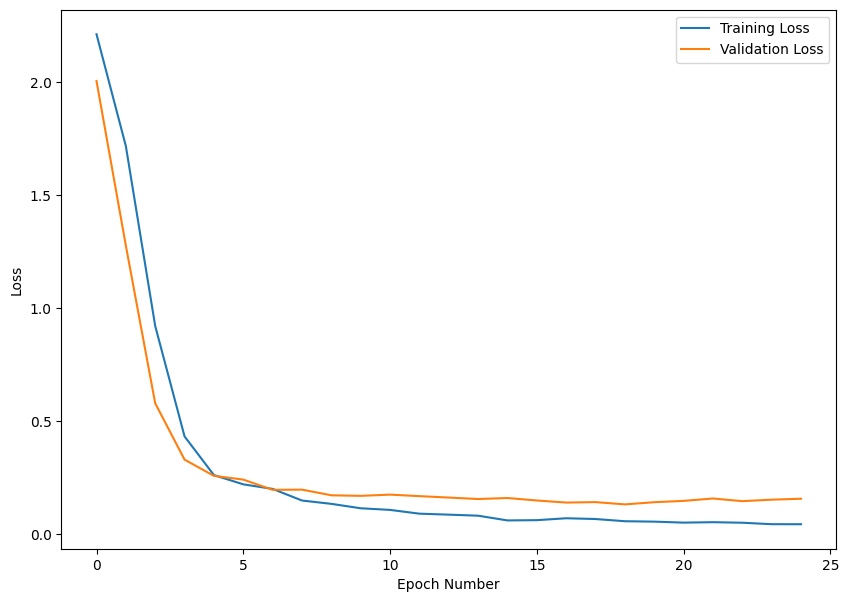

In [23]:
plt.figure(figsize=(10, 7))
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.savefig('loss_curve.png')
plt.show()

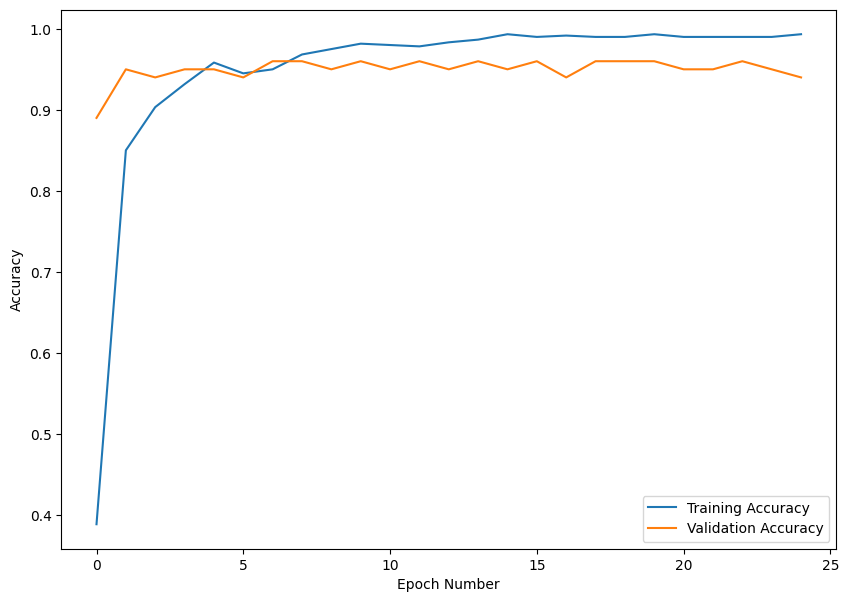

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(history[:,2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.savefig('accuracy_curve.png')
plt.show()

In [25]:
def computeTestSetAccuracy(model, loss_criterion):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to test_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate test accuracy
            _, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to test_acc
            test_acc += acc.item() * inputs.size(0)

            print(f"Test Batch number: {j:03d}, Test: Loss: {loss.item():.4f}, Accuracy: {acc.item():.4f}")

    # Find average test loss and test accuracy
    avg_test_loss = test_loss / test_data_size
    avg_test_acc = test_acc / test_data_size

    print("Test accuracy: {:.4f}".format(avg_test_acc))

In [27]:
# Load the model with weights_only=False to load the entire model structure
model = torch.load("best_model.pt", weights_only=False)
# Evaluate the model's performance on the test dataset and print the results.
computeTestSetAccuracy(model, criterion)

Test Batch number: 000, Test: Loss: 0.1417, Accuracy: 0.9688
Test Batch number: 001, Test: Loss: 0.2173, Accuracy: 0.9062
Test Batch number: 002, Test: Loss: 0.0141, Accuracy: 1.0000
Test Batch number: 003, Test: Loss: 0.0012, Accuracy: 1.0000
Test accuracy: 0.9600


In [28]:
def predict(model, test_image_name):
    """
    Predicts the class of a given test image using a trained model.

    Parameters:
    model (torch.nn.Module): The trained model to use for prediction.
    test_image_name (str): The file path of the test image.

    The function loads the image, applies necessary transformations, and
    passes it through the model to get the top 3 predictions with their confidence scores.
    """
    # Applies the predefined transformation pipeline for test images
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)

    # Creates a figure to visualize the test image
    plt.figure(figsize=(10, 7))
    plt.imshow(test_image)  # Displays the test image before applying transformations
    plt.axis('off')  # Removes the axis for a cleaner image visualization

    # Apply transformations and reshape to fit model input
    test_image_tensor = transform(test_image)
    test_image_tensor = test_image_tensor.view(1, 3, 224, 224)  # Reshape for batch processing

    # Checks if a GPU is available and moves the tensor to CUDA if possible
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.cuda()

    with torch.no_grad():  # Disables gradient computation to optimize inference performance
        model.eval()  # Set model to evaluation mode
        out = model(test_image_tensor)  # Get model predictions
        ps = torch.exp(out)  # Convert log probabilities to actual probabilities

        # Extract the top 3 predictions and their probabilities
        topk, topclass = ps.topk(3, dim=1)
        cls = idx_to_class[topclass.cpu().numpy()[0][0]]  # Get the top predicted class
        score = topk.cpu().numpy()[0][0]  # Get the top prediction confidence score

        # Print the top 3 predictions with their confidence scores
        for i in range(3):
            print(f"Prediction {i+1}: {idx_to_class[topclass.cpu().numpy()[0][i]]}",
                  f"Score: {topk.cpu().numpy()[0][i]*100:.3f}%")

In [29]:
!wget -q "https://learnopencv.com/wp-content/uploads/2022/10/skunk.jpg" -O "skunk.jpg"
!wget -q "https://learnopencv.com/wp-content/uploads/2024/02/Zebra.jpg" -O "Zebra.jpg"
!wget -q "https://learnopencv.com/wp-content/uploads/2024/07/llama-scaled.jpg" -O "llama.jpg"
!wget -q "https://learnopencv.com/wp-content/uploads/2024/07/llama_-scaled.jpg" -O "llama_.jpg"

Prediction 1: skunk Score: 99.842%
Prediction 2: porcupine Score: 0.099%
Prediction 3: chimp Score: 0.017%


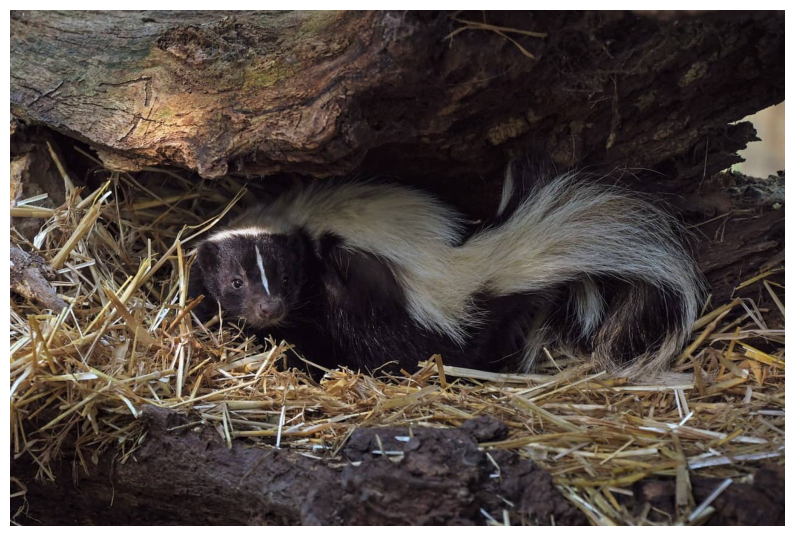

In [30]:
predict(model, 'skunk.jpg')

Prediction 1: zebra Score: 99.973%
Prediction 2: giraffe Score: 0.015%
Prediction 3: ostrich Score: 0.004%


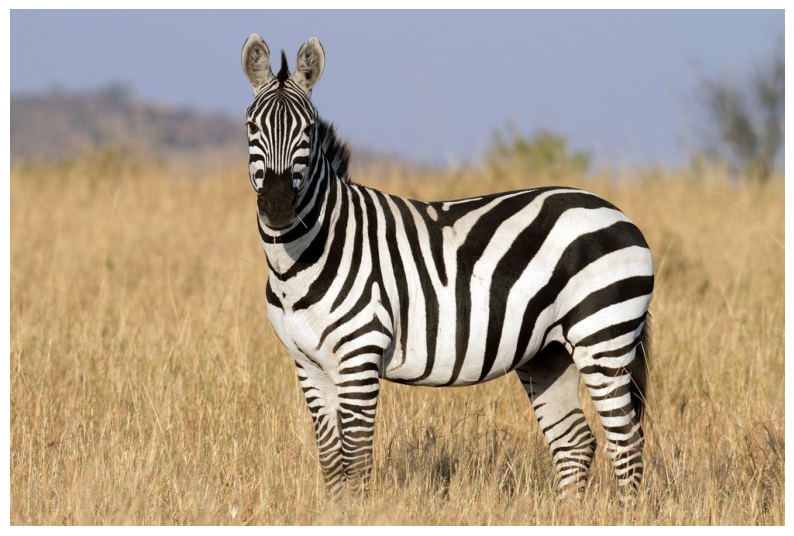

In [31]:
predict(model, 'Zebra.jpg')